## P-set 3


# 1) 20 points

Considering the Pauli-Y gate as an observable:
- Choose an Ansatz (parameterized quantum circuit) that is able to capture the minimum eigenvalu of this observable.
- Write a function that takes a parameter (float) as input and returns your ansatz as parameterized quntum circuit. (Use Qiskit)


Mein ansatz st Rx(𝜃)

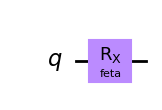

In [64]:
from qiskit import QuantumCircuit

def ansatz_y(parameter = Parameter('feta')):

    qc = QuantumCircuit(1)
    
    qc.rx(parameter, 0)
    
    return qc

ansatz_y().draw('mpl')

# 2) 20 points

Visualize the problem landscape:
- evaluate the expectation value for the Pauli-Y observable and your choice of Ansatz for various parameters.
The plot should depict the input parameters on the x-axis and the respective expectation value on the y axis.
(Use Qiskit).
- For what parameter is the expectation value minimal? Does that match your solution from p-set 2? (Answere in text.)

Hint: 100 parameters ranging from 0 to 4 $\pi$ should capture your problem landscape adequately)

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as tck

from qiskit.circuit import Parameter
from qiskit.quantum_info import SparsePauliOp
from qiskit.quantum_info.operators import Operator
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Options, Estimator
from qiskit.algorithms.optimizers import SPSA
from qiskit import QuantumCircuit, QuantumRegister

In [66]:
ops = SparsePauliOp.from_list([("Y", 1)])

In [67]:
# Establish a Qiskit Runtime Session
service = QiskitRuntimeService(channel='ibm_quantum')
sim_backend = service.backends('ibmq_qasm_simulator')[0]

print(sim_backend)

<IBMBackend('ibmq_qasm_simulator')>


In [68]:
# Define the parameter values you want to evaluate
params_range = np.linspace(0, 4*np.pi, 100)
phases  = [[ph] for ph in params_range ]

In [74]:
# Evaluate the expectation value of an operator

with Session(service=service, backend=sim_backend) as session: 
    estimator = Estimator(session=session)
    result = estimator.run(circuits=[ansatz_y()]*len(phases) ,parameter_values=phases ,observables=[ops]*len(phases)).result()
print(result.values)

base_primitive._run_primitive:INFO:2023-11-09 22:52:35,363: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


[ 0.0155 -0.1195 -0.2765 -0.3475 -0.481  -0.5895 -0.706  -0.786  -0.845
 -0.909  -0.953  -0.9845 -0.999  -0.9975 -0.98   -0.9355 -0.8995 -0.84
 -0.748  -0.6625 -0.556  -0.4605 -0.343  -0.2315 -0.1045  0.0355  0.129
  0.2875  0.425   0.5065  0.595   0.7005  0.787   0.8835  0.922   0.9605
  0.9915  1.      0.994   0.9695  0.9335  0.8825  0.8115  0.7375  0.6345
  0.521   0.4385  0.292   0.177   0.055  -0.0635 -0.202  -0.29   -0.3975
 -0.542  -0.63   -0.7405 -0.813  -0.8735 -0.9385 -0.971  -0.995  -1.
 -0.9905 -0.965  -0.927  -0.8675 -0.7855 -0.7255 -0.617  -0.503  -0.413
 -0.269  -0.1475 -0.0435  0.086   0.202   0.345   0.4615  0.578   0.622
  0.768   0.8365  0.903   0.943   0.98    0.996   0.9995  0.989   0.956
  0.909   0.8305  0.785   0.683   0.594   0.4595  0.382   0.23    0.133
 -0.02  ]


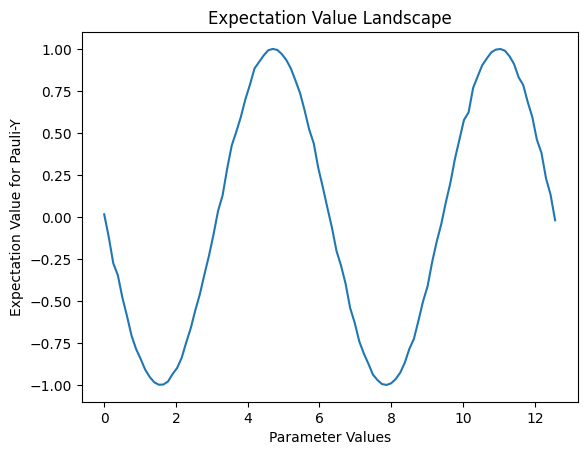

In [77]:
plt.plot(params_range, result.values)
plt.xlabel('Parameter Values')
plt.ylabel('Expectation Value for Pauli-Y')
plt.title('Expectation Value Landscape')
plt.show()

### The minimal value is -1 and is reached twice at pi/2 and 5pi/2

# 3) 60 points

Choosing the Pauli-Y gate as your observable: Write your custom VQE routine to infer the minimal eigenvalue of this observable with your choice of Ansatz. (Use Qiskit)

Feel free to experiment with different optimizers and respective hyperparameters


In [82]:
# Define the VQE routine to infer the minimal expectation value
def custom_vqe_estimator(estimator,ansatz,ops,optimizer=None,initial_point=None):
    energy_list = []
    param_list = []
    
    #Objective function is the expectation value E = <psi(theta)|OPS|psi(theta)>
    def objective_function(params):
        # The cost is the expectation value of the observable
        result = estimator.run(circuits=[ansatz], parameter_values=params,observables=ops).result()
        cost = result.values[0]
 
        print(f'Backend: {estimator.session.backend()} - Cost: {cost}')
        return cost
    
    # Call back function
    def callback(x,fx,ax,tx,nx):
    # Callback function to get a view on internal states and statistics of the optimizer for visualization
        energy_list.append(ax)
        param_list.append(fx)
            
    if initial_point is None:
        initial_point = np.random.random(ansatz.num_parameters)

    if optimizer == None:
        # Define optimizer and pass callback function
        
        optimizer = SPSA(maxiter=10, callback=callback)
        
       # Define minimize function
    result =  optimizer.minimize(fun=objective_function,x0=initial_point)


    return  param_list, energy_list, result  

In [ ]:
from qiskit.algorithms.optimizers import NFT

rizz = custom_vqe_estimator(estimator,ansatz_y(),ops, optimizer=NFT())

base_primitive._run_primitive:INFO:2023-11-09 23:28:35,304: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}
base_primitive._run_primitive:INFO:2023-11-09 23:28:39,890: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_trans

Backend: ibmq_qasm_simulator - Cost: -0.7465


base_primitive._run_primitive:INFO:2023-11-09 23:28:43,161: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.671


base_primitive._run_primitive:INFO:2023-11-09 23:28:46,820: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.637


base_primitive._run_primitive:INFO:2023-11-09 23:28:50,260: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.0265


base_primitive._run_primitive:INFO:2023-11-09 23:28:53,588: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.003


base_primitive._run_primitive:INFO:2023-11-09 23:28:58,602: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.022


base_primitive._run_primitive:INFO:2023-11-09 23:29:01,962: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.0125


base_primitive._run_primitive:INFO:2023-11-09 23:29:05,865: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.039


base_primitive._run_primitive:INFO:2023-11-09 23:29:09,560: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.03


base_primitive._run_primitive:INFO:2023-11-09 23:29:13,385: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.002


base_primitive._run_primitive:INFO:2023-11-09 23:29:17,944: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.019


base_primitive._run_primitive:INFO:2023-11-09 23:29:21,969: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.015


base_primitive._run_primitive:INFO:2023-11-09 23:29:28,779: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.0065


base_primitive._run_primitive:INFO:2023-11-09 23:29:33,621: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.016


base_primitive._run_primitive:INFO:2023-11-09 23:29:37,785: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.0025


base_primitive._run_primitive:INFO:2023-11-09 23:29:42,644: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.0305


base_primitive._run_primitive:INFO:2023-11-09 23:29:46,732: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.043


base_primitive._run_primitive:INFO:2023-11-09 23:29:52,059: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.0005


base_primitive._run_primitive:INFO:2023-11-09 23:32:16,637: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.0095


base_primitive._run_primitive:INFO:2023-11-09 23:32:24,849: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.0185


base_primitive._run_primitive:INFO:2023-11-09 23:32:30,203: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.0105


base_primitive._run_primitive:INFO:2023-11-09 23:32:38,351: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.0135


base_primitive._run_primitive:INFO:2023-11-09 23:32:42,829: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.0185


base_primitive._run_primitive:INFO:2023-11-09 23:32:47,973: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.002


base_primitive._run_primitive:INFO:2023-11-09 23:32:55,569: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.025


base_primitive._run_primitive:INFO:2023-11-09 23:33:00,505: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.0145


base_primitive._run_primitive:INFO:2023-11-09 23:33:05,065: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.0105


base_primitive._run_primitive:INFO:2023-11-09 23:33:10,886: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.0075


base_primitive._run_primitive:INFO:2023-11-09 23:33:16,844: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.008


base_primitive._run_primitive:INFO:2023-11-09 23:33:21,125: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.0075


base_primitive._run_primitive:INFO:2023-11-09 23:33:26,688: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.006


base_primitive._run_primitive:INFO:2023-11-09 23:33:31,625: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.019


base_primitive._run_primitive:INFO:2023-11-09 23:33:36,567: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.001


base_primitive._run_primitive:INFO:2023-11-09 23:33:42,178: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.018


base_primitive._run_primitive:INFO:2023-11-09 23:33:46,725: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.003


base_primitive._run_primitive:INFO:2023-11-09 23:33:50,981: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.034


base_primitive._run_primitive:INFO:2023-11-09 23:33:54,597: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.0035


base_primitive._run_primitive:INFO:2023-11-09 23:33:58,029: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.0075


base_primitive._run_primitive:INFO:2023-11-09 23:34:01,685: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.0205


base_primitive._run_primitive:INFO:2023-11-09 23:34:06,425: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.001


base_primitive._run_primitive:INFO:2023-11-09 23:34:10,461: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.034


base_primitive._run_primitive:INFO:2023-11-09 23:34:15,260: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.0095


base_primitive._run_primitive:INFO:2023-11-09 23:34:19,614: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.0055


base_primitive._run_primitive:INFO:2023-11-09 23:34:23,136: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.023


base_primitive._run_primitive:INFO:2023-11-09 23:34:30,780: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.035


base_primitive._run_primitive:INFO:2023-11-09 23:34:36,004: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.019


base_primitive._run_primitive:INFO:2023-11-09 23:34:43,992: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.019


base_primitive._run_primitive:INFO:2023-11-09 23:34:48,348: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.006


base_primitive._run_primitive:INFO:2023-11-09 23:34:52,614: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.001


base_primitive._run_primitive:INFO:2023-11-09 23:34:57,313: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.0165


base_primitive._run_primitive:INFO:2023-11-09 23:35:01,936: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.0


base_primitive._run_primitive:INFO:2023-11-09 23:35:10,768: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.0075


base_primitive._run_primitive:INFO:2023-11-09 23:35:15,021: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.0135


base_primitive._run_primitive:INFO:2023-11-09 23:35:18,971: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.0095


base_primitive._run_primitive:INFO:2023-11-09 23:35:26,188: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.0225


base_primitive._run_primitive:INFO:2023-11-09 23:35:30,073: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.0015


base_primitive._run_primitive:INFO:2023-11-09 23:35:33,830: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.064


base_primitive._run_primitive:INFO:2023-11-09 23:35:38,225: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.0025


base_primitive._run_primitive:INFO:2023-11-09 23:35:42,422: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.033


base_primitive._run_primitive:INFO:2023-11-09 23:35:47,885: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.0145


base_primitive._run_primitive:INFO:2023-11-09 23:35:51,634: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.003


base_primitive._run_primitive:INFO:2023-11-09 23:35:56,736: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.006


base_primitive._run_primitive:INFO:2023-11-09 23:36:00,037: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.0075


base_primitive._run_primitive:INFO:2023-11-09 23:36:05,721: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.023


base_primitive._run_primitive:INFO:2023-11-09 23:36:08,947: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.0045


base_primitive._run_primitive:INFO:2023-11-09 23:36:12,149: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -1.0


base_primitive._run_primitive:INFO:2023-11-09 23:36:15,577: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.0205


base_primitive._run_primitive:INFO:2023-11-09 23:36:19,040: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.032


base_primitive._run_primitive:INFO:2023-11-09 23:36:22,440: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.0285


base_primitive._run_primitive:INFO:2023-11-09 23:36:26,525: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.0285


base_primitive._run_primitive:INFO:2023-11-09 23:36:29,739: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.0055


base_primitive._run_primitive:INFO:2023-11-09 23:36:33,100: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.0185


base_primitive._run_primitive:INFO:2023-11-09 23:36:36,410: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.024


base_primitive._run_primitive:INFO:2023-11-09 23:36:39,734: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.006


base_primitive._run_primitive:INFO:2023-11-09 23:36:42,911: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.014


base_primitive._run_primitive:INFO:2023-11-09 23:36:46,069: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.0085


base_primitive._run_primitive:INFO:2023-11-09 23:36:49,230: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.0215


base_primitive._run_primitive:INFO:2023-11-09 23:36:52,666: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.0205


base_primitive._run_primitive:INFO:2023-11-09 23:36:56,104: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.02


base_primitive._run_primitive:INFO:2023-11-09 23:36:59,450: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.0455


base_primitive._run_primitive:INFO:2023-11-09 23:37:03,105: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.068


base_primitive._run_primitive:INFO:2023-11-09 23:37:06,434: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.012


base_primitive._run_primitive:INFO:2023-11-09 23:37:09,690: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.0125


base_primitive._run_primitive:INFO:2023-11-09 23:37:13,247: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.0115


base_primitive._run_primitive:INFO:2023-11-09 23:37:16,756: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.031


base_primitive._run_primitive:INFO:2023-11-09 23:37:20,510: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.0065


base_primitive._run_primitive:INFO:2023-11-09 23:37:23,784: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.0265


base_primitive._run_primitive:INFO:2023-11-09 23:37:27,215: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.017


base_primitive._run_primitive:INFO:2023-11-09 23:37:31,039: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.007


base_primitive._run_primitive:INFO:2023-11-09 23:37:35,114: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.0055


base_primitive._run_primitive:INFO:2023-11-09 23:37:38,250: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.011


base_primitive._run_primitive:INFO:2023-11-09 23:37:42,106: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.003


base_primitive._run_primitive:INFO:2023-11-09 23:37:45,463: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.038


base_primitive._run_primitive:INFO:2023-11-09 23:37:48,832: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.006


base_primitive._run_primitive:INFO:2023-11-09 23:37:52,305: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.021


base_primitive._run_primitive:INFO:2023-11-09 23:37:55,410: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.005


base_primitive._run_primitive:INFO:2023-11-09 23:37:58,565: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.0025


base_primitive._run_primitive:INFO:2023-11-09 23:38:02,221: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.009


base_primitive._run_primitive:INFO:2023-11-09 23:38:05,522: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.021


base_primitive._run_primitive:INFO:2023-11-09 23:38:08,656: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.018


base_primitive._run_primitive:INFO:2023-11-09 23:38:11,846: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.006


base_primitive._run_primitive:INFO:2023-11-09 23:38:15,327: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.0125


base_primitive._run_primitive:INFO:2023-11-09 23:38:18,842: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.009


base_primitive._run_primitive:INFO:2023-11-09 23:38:21,920: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.0075


base_primitive._run_primitive:INFO:2023-11-09 23:38:25,217: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.006


base_primitive._run_primitive:INFO:2023-11-09 23:38:28,723: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.0185


base_primitive._run_primitive:INFO:2023-11-09 23:38:32,972: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.014


base_primitive._run_primitive:INFO:2023-11-09 23:38:36,429: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.0005


base_primitive._run_primitive:INFO:2023-11-09 23:38:40,192: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.009


base_primitive._run_primitive:INFO:2023-11-09 23:38:43,905: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.0135


base_primitive._run_primitive:INFO:2023-11-09 23:38:47,240: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.026


base_primitive._run_primitive:INFO:2023-11-09 23:38:50,953: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.0005


base_primitive._run_primitive:INFO:2023-11-09 23:38:54,605: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.0175


base_primitive._run_primitive:INFO:2023-11-09 23:38:58,049: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.035


base_primitive._run_primitive:INFO:2023-11-09 23:39:01,477: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.041


base_primitive._run_primitive:INFO:2023-11-09 23:39:04,924: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.004


base_primitive._run_primitive:INFO:2023-11-09 23:39:09,126: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.017


base_primitive._run_primitive:INFO:2023-11-09 23:39:12,935: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.017


base_primitive._run_primitive:INFO:2023-11-09 23:39:16,699: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.0275


base_primitive._run_primitive:INFO:2023-11-09 23:39:20,208: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.0115


base_primitive._run_primitive:INFO:2023-11-09 23:39:24,561: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.007


base_primitive._run_primitive:INFO:2023-11-09 23:39:28,873: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.035


base_primitive._run_primitive:INFO:2023-11-09 23:39:32,115: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.002


base_primitive._run_primitive:INFO:2023-11-09 23:39:35,791: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.014


base_primitive._run_primitive:INFO:2023-11-09 23:39:39,359: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.0235


base_primitive._run_primitive:INFO:2023-11-09 23:39:42,878: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.0065


base_primitive._run_primitive:INFO:2023-11-09 23:39:46,416: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.0085


base_primitive._run_primitive:INFO:2023-11-09 23:39:49,977: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.001


base_primitive._run_primitive:INFO:2023-11-09 23:39:53,374: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.015


base_primitive._run_primitive:INFO:2023-11-09 23:39:56,896: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.0195


base_primitive._run_primitive:INFO:2023-11-09 23:40:01,024: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.9995


base_primitive._run_primitive:INFO:2023-11-09 23:40:05,256: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.016


base_primitive._run_primitive:INFO:2023-11-09 23:40:08,482: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.0165


base_primitive._run_primitive:INFO:2023-11-09 23:40:12,227: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.0115


base_primitive._run_primitive:INFO:2023-11-09 23:40:15,598: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.0105


base_primitive._run_primitive:INFO:2023-11-09 23:40:19,368: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.012


base_primitive._run_primitive:INFO:2023-11-09 23:40:22,962: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.0055


base_primitive._run_primitive:INFO:2023-11-09 23:40:26,582: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.01


base_primitive._run_primitive:INFO:2023-11-09 23:40:30,793: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.019


base_primitive._run_primitive:INFO:2023-11-09 23:40:35,510: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.0315


base_primitive._run_primitive:INFO:2023-11-09 23:40:39,034: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.0135


base_primitive._run_primitive:INFO:2023-11-09 23:40:42,969: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.0075


base_primitive._run_primitive:INFO:2023-11-09 23:40:46,741: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.015


base_primitive._run_primitive:INFO:2023-11-09 23:40:50,094: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.014


base_primitive._run_primitive:INFO:2023-11-09 23:40:53,590: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.0105


base_primitive._run_primitive:INFO:2023-11-09 23:40:58,294: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.0215


base_primitive._run_primitive:INFO:2023-11-09 23:41:03,004: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.0025


base_primitive._run_primitive:INFO:2023-11-09 23:41:06,733: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.0115


base_primitive._run_primitive:INFO:2023-11-09 23:41:10,338: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.0155


base_primitive._run_primitive:INFO:2023-11-09 23:41:13,962: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.0075


base_primitive._run_primitive:INFO:2023-11-09 23:41:17,708: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.001


base_primitive._run_primitive:INFO:2023-11-09 23:41:21,330: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.0255


base_primitive._run_primitive:INFO:2023-11-09 23:41:24,814: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.0305


base_primitive._run_primitive:INFO:2023-11-09 23:41:28,871: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.0155


base_primitive._run_primitive:INFO:2023-11-09 23:41:32,651: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.0225


base_primitive._run_primitive:INFO:2023-11-09 23:41:36,488: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.0185


base_primitive._run_primitive:INFO:2023-11-09 23:41:41,118: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.001


base_primitive._run_primitive:INFO:2023-11-09 23:41:46,118: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.0045


base_primitive._run_primitive:INFO:2023-11-09 23:41:51,206: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.037


base_primitive._run_primitive:INFO:2023-11-09 23:41:57,070: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.0095


base_primitive._run_primitive:INFO:2023-11-09 23:42:03,176: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.01


base_primitive._run_primitive:INFO:2023-11-09 23:42:16,290: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.0155


base_primitive._run_primitive:INFO:2023-11-09 23:42:19,886: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.0015


base_primitive._run_primitive:INFO:2023-11-09 23:42:23,654: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.0035


base_primitive._run_primitive:INFO:2023-11-09 23:42:27,302: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.0125


base_primitive._run_primitive:INFO:2023-11-09 23:42:30,674: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.0005


base_primitive._run_primitive:INFO:2023-11-09 23:42:33,987: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.0175


base_primitive._run_primitive:INFO:2023-11-09 23:42:37,325: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.019


base_primitive._run_primitive:INFO:2023-11-09 23:42:40,750: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.009


base_primitive._run_primitive:INFO:2023-11-09 23:42:45,395: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.012


base_primitive._run_primitive:INFO:2023-11-09 23:42:48,804: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.019


base_primitive._run_primitive:INFO:2023-11-09 23:42:52,491: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.0235


base_primitive._run_primitive:INFO:2023-11-09 23:42:55,649: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.001


base_primitive._run_primitive:INFO:2023-11-09 23:42:59,060: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.038


base_primitive._run_primitive:INFO:2023-11-09 23:43:02,406: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.0335


base_primitive._run_primitive:INFO:2023-11-09 23:43:05,773: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.01


base_primitive._run_primitive:INFO:2023-11-09 23:43:08,971: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.015


base_primitive._run_primitive:INFO:2023-11-09 23:43:11,989: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.0335


base_primitive._run_primitive:INFO:2023-11-09 23:43:15,233: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.004


base_primitive._run_primitive:INFO:2023-11-09 23:43:18,664: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.0385


base_primitive._run_primitive:INFO:2023-11-09 23:43:22,102: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.004


base_primitive._run_primitive:INFO:2023-11-09 23:43:25,653: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.0015


base_primitive._run_primitive:INFO:2023-11-09 23:43:29,339: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.0035


base_primitive._run_primitive:INFO:2023-11-09 23:43:40,299: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.0185


base_primitive._run_primitive:INFO:2023-11-09 23:43:43,633: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.002


base_primitive._run_primitive:INFO:2023-11-09 23:43:54,513: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.011


base_primitive._run_primitive:INFO:2023-11-09 23:43:58,990: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.0415


base_primitive._run_primitive:INFO:2023-11-09 23:44:02,499: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.053


base_primitive._run_primitive:INFO:2023-11-09 23:44:06,206: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.0535


base_primitive._run_primitive:INFO:2023-11-09 23:44:09,739: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.0205


base_primitive._run_primitive:INFO:2023-11-09 23:44:13,261: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.031


base_primitive._run_primitive:INFO:2023-11-09 23:44:16,913: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.016


base_primitive._run_primitive:INFO:2023-11-09 23:44:20,086: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.007


base_primitive._run_primitive:INFO:2023-11-09 23:44:23,882: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.0205


base_primitive._run_primitive:INFO:2023-11-09 23:44:27,630: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.0025


base_primitive._run_primitive:INFO:2023-11-09 23:44:30,859: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -1.0


base_primitive._run_primitive:INFO:2023-11-09 23:44:34,267: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.0155


base_primitive._run_primitive:INFO:2023-11-09 23:44:37,670: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.0385


base_primitive._run_primitive:INFO:2023-11-09 23:44:40,739: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.0065


base_primitive._run_primitive:INFO:2023-11-09 23:44:43,853: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.0625


base_primitive._run_primitive:INFO:2023-11-09 23:44:47,687: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.011


base_primitive._run_primitive:INFO:2023-11-09 23:44:50,744: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.001


base_primitive._run_primitive:INFO:2023-11-09 23:44:53,821: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.0035


base_primitive._run_primitive:INFO:2023-11-09 23:44:57,025: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.0135


base_primitive._run_primitive:INFO:2023-11-09 23:45:00,653: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.017


base_primitive._run_primitive:INFO:2023-11-09 23:45:13,701: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.0195


base_primitive._run_primitive:INFO:2023-11-09 23:45:17,837: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.0245


base_primitive._run_primitive:INFO:2023-11-09 23:45:28,733: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.019


base_primitive._run_primitive:INFO:2023-11-09 23:45:32,458: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.0085


base_primitive._run_primitive:INFO:2023-11-09 23:45:36,113: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.0085


base_primitive._run_primitive:INFO:2023-11-09 23:45:39,580: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.0105


base_primitive._run_primitive:INFO:2023-11-09 23:45:43,049: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.0295


base_primitive._run_primitive:INFO:2023-11-09 23:45:46,688: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.003


base_primitive._run_primitive:INFO:2023-11-09 23:45:50,233: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.002


base_primitive._run_primitive:INFO:2023-11-09 23:45:53,321: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.032


base_primitive._run_primitive:INFO:2023-11-09 23:45:57,426: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.0055


base_primitive._run_primitive:INFO:2023-11-09 23:46:00,821: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.027


base_primitive._run_primitive:INFO:2023-11-09 23:46:03,931: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.0065


base_primitive._run_primitive:INFO:2023-11-09 23:46:07,281: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.0245


base_primitive._run_primitive:INFO:2023-11-09 23:46:10,801: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.009


base_primitive._run_primitive:INFO:2023-11-09 23:46:13,999: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.0135


base_primitive._run_primitive:INFO:2023-11-09 23:46:17,225: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.0


base_primitive._run_primitive:INFO:2023-11-09 23:46:20,891: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.024


base_primitive._run_primitive:INFO:2023-11-09 23:46:24,249: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.0195


base_primitive._run_primitive:INFO:2023-11-09 23:46:28,116: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.0185


base_primitive._run_primitive:INFO:2023-11-09 23:46:34,756: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.0355


base_primitive._run_primitive:INFO:2023-11-09 23:46:41,567: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.021


base_primitive._run_primitive:INFO:2023-11-09 23:46:45,482: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.0135


base_primitive._run_primitive:INFO:2023-11-09 23:46:53,988: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.0195


base_primitive._run_primitive:INFO:2023-11-09 23:46:58,083: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.015


base_primitive._run_primitive:INFO:2023-11-09 23:47:02,206: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.019


base_primitive._run_primitive:INFO:2023-11-09 23:47:06,013: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.017


base_primitive._run_primitive:INFO:2023-11-09 23:47:10,429: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.0135


base_primitive._run_primitive:INFO:2023-11-09 23:47:13,956: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.0285


base_primitive._run_primitive:INFO:2023-11-09 23:47:17,093: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.0515


base_primitive._run_primitive:INFO:2023-11-09 23:47:20,490: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.0495


base_primitive._run_primitive:INFO:2023-11-09 23:47:24,046: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.0305


base_primitive._run_primitive:INFO:2023-11-09 23:47:28,372: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.043


base_primitive._run_primitive:INFO:2023-11-09 23:47:31,957: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.0075


base_primitive._run_primitive:INFO:2023-11-09 23:47:35,157: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.003


base_primitive._run_primitive:INFO:2023-11-09 23:47:38,493: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.0115


base_primitive._run_primitive:INFO:2023-11-09 23:47:41,844: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.0035


base_primitive._run_primitive:INFO:2023-11-09 23:47:44,998: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.0275


base_primitive._run_primitive:INFO:2023-11-09 23:47:52,418: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.001


base_primitive._run_primitive:INFO:2023-11-09 23:47:55,908: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.004


base_primitive._run_primitive:INFO:2023-11-09 23:48:08,047: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.016


base_primitive._run_primitive:INFO:2023-11-09 23:48:11,280: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.008


base_primitive._run_primitive:INFO:2023-11-09 23:48:14,233: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.017


base_primitive._run_primitive:INFO:2023-11-09 23:48:17,693: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.052


base_primitive._run_primitive:INFO:2023-11-09 23:48:29,718: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.0055


base_primitive._run_primitive:INFO:2023-11-09 23:48:33,230: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.029


base_primitive._run_primitive:INFO:2023-11-09 23:48:37,219: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.0205


base_primitive._run_primitive:INFO:2023-11-09 23:48:40,357: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.0055


base_primitive._run_primitive:INFO:2023-11-09 23:48:43,566: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.028


base_primitive._run_primitive:INFO:2023-11-09 23:48:47,229: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.04


base_primitive._run_primitive:INFO:2023-11-09 23:48:51,016: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.013


base_primitive._run_primitive:INFO:2023-11-09 23:48:54,295: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.001


base_primitive._run_primitive:INFO:2023-11-09 23:48:57,985: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.036


base_primitive._run_primitive:INFO:2023-11-09 23:49:01,777: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.0025


base_primitive._run_primitive:INFO:2023-11-09 23:49:04,901: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.013


base_primitive._run_primitive:INFO:2023-11-09 23:49:08,620: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -1.0


base_primitive._run_primitive:INFO:2023-11-09 23:49:12,390: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.0035


base_primitive._run_primitive:INFO:2023-11-09 23:49:15,743: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.002


base_primitive._run_primitive:INFO:2023-11-09 23:49:19,347: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.023


base_primitive._run_primitive:INFO:2023-11-09 23:49:22,992: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.003


base_primitive._run_primitive:INFO:2023-11-09 23:49:26,459: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.011


base_primitive._run_primitive:INFO:2023-11-09 23:49:35,964: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.001


base_primitive._run_primitive:INFO:2023-11-09 23:49:39,421: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.038


base_primitive._run_primitive:INFO:2023-11-09 23:49:43,076: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.038


base_primitive._run_primitive:INFO:2023-11-09 23:49:47,201: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.0255


base_primitive._run_primitive:INFO:2023-11-09 23:49:51,739: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.0625


base_primitive._run_primitive:INFO:2023-11-09 23:49:59,841: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.012


base_primitive._run_primitive:INFO:2023-11-09 23:50:03,155: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.0285


base_primitive._run_primitive:INFO:2023-11-09 23:50:06,904: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.011


base_primitive._run_primitive:INFO:2023-11-09 23:50:10,308: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.008


base_primitive._run_primitive:INFO:2023-11-09 23:50:13,718: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.021


base_primitive._run_primitive:INFO:2023-11-09 23:50:17,270: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.013


base_primitive._run_primitive:INFO:2023-11-09 23:50:20,258: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.0345


base_primitive._run_primitive:INFO:2023-11-09 23:50:23,498: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.018


base_primitive._run_primitive:INFO:2023-11-09 23:50:26,709: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.02


base_primitive._run_primitive:INFO:2023-11-09 23:50:30,526: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.012


base_primitive._run_primitive:INFO:2023-11-09 23:50:33,766: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.0115


base_primitive._run_primitive:INFO:2023-11-09 23:50:37,238: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.0175


base_primitive._run_primitive:INFO:2023-11-09 23:50:41,399: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.004


base_primitive._run_primitive:INFO:2023-11-09 23:50:44,713: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.0075


base_primitive._run_primitive:INFO:2023-11-09 23:50:47,955: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.004


base_primitive._run_primitive:INFO:2023-11-09 23:50:57,430: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.0245


base_primitive._run_primitive:INFO:2023-11-09 23:51:00,772: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.033


base_primitive._run_primitive:INFO:2023-11-09 23:51:04,253: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.001


base_primitive._run_primitive:INFO:2023-11-09 23:51:07,882: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.009


base_primitive._run_primitive:INFO:2023-11-09 23:51:11,341: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.023


base_primitive._run_primitive:INFO:2023-11-09 23:51:15,722: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.001


base_primitive._run_primitive:INFO:2023-11-09 23:51:19,600: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.0045


base_primitive._run_primitive:INFO:2023-11-09 23:51:23,589: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.033


base_primitive._run_primitive:INFO:2023-11-09 23:51:26,818: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.009


base_primitive._run_primitive:INFO:2023-11-09 23:51:30,690: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.0305


base_primitive._run_primitive:INFO:2023-11-09 23:51:34,118: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.014


base_primitive._run_primitive:INFO:2023-11-09 23:51:46,402: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.0


base_primitive._run_primitive:INFO:2023-11-09 23:51:50,302: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.0085


base_primitive._run_primitive:INFO:2023-11-09 23:51:54,057: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.018


base_primitive._run_primitive:INFO:2023-11-09 23:51:57,590: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.0


base_primitive._run_primitive:INFO:2023-11-09 23:52:01,200: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.022


base_primitive._run_primitive:INFO:2023-11-09 23:52:04,189: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.0195


base_primitive._run_primitive:INFO:2023-11-09 23:52:07,770: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.0155


base_primitive._run_primitive:INFO:2023-11-09 23:52:11,524: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.018


base_primitive._run_primitive:INFO:2023-11-09 23:52:14,873: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.0135


base_primitive._run_primitive:INFO:2023-11-09 23:52:18,479: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.0375


base_primitive._run_primitive:INFO:2023-11-09 23:52:26,130: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.0195


base_primitive._run_primitive:INFO:2023-11-09 23:52:29,754: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.0115


base_primitive._run_primitive:INFO:2023-11-09 23:52:33,273: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.001


base_primitive._run_primitive:INFO:2023-11-09 23:52:36,976: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.0115


base_primitive._run_primitive:INFO:2023-11-09 23:52:40,293: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.0295


base_primitive._run_primitive:INFO:2023-11-09 23:52:43,874: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.004


base_primitive._run_primitive:INFO:2023-11-09 23:52:47,576: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.0135


base_primitive._run_primitive:INFO:2023-11-09 23:52:51,254: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.005


base_primitive._run_primitive:INFO:2023-11-09 23:52:54,980: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.007


base_primitive._run_primitive:INFO:2023-11-09 23:52:58,429: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.0015


base_primitive._run_primitive:INFO:2023-11-09 23:53:02,378: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.012


base_primitive._run_primitive:INFO:2023-11-09 23:53:14,580: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.019


base_primitive._run_primitive:INFO:2023-11-09 23:53:17,918: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.0315


base_primitive._run_primitive:INFO:2023-11-09 23:53:21,781: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.0025


base_primitive._run_primitive:INFO:2023-11-09 23:53:25,000: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.0065


base_primitive._run_primitive:INFO:2023-11-09 23:53:28,271: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.005


base_primitive._run_primitive:INFO:2023-11-09 23:53:31,631: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.0055


base_primitive._run_primitive:INFO:2023-11-09 23:53:35,007: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.006


base_primitive._run_primitive:INFO:2023-11-09 23:53:39,014: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -1.0


base_primitive._run_primitive:INFO:2023-11-09 23:53:45,523: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.0005


base_primitive._run_primitive:INFO:2023-11-09 23:53:48,761: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.0035


base_primitive._run_primitive:INFO:2023-11-09 23:53:52,127: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.0


base_primitive._run_primitive:INFO:2023-11-09 23:53:55,492: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.04


base_primitive._run_primitive:INFO:2023-11-09 23:53:58,589: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.001


base_primitive._run_primitive:INFO:2023-11-09 23:54:01,874: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.016


base_primitive._run_primitive:INFO:2023-11-09 23:54:05,021: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.0155


base_primitive._run_primitive:INFO:2023-11-09 23:54:08,144: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.0135


base_primitive._run_primitive:INFO:2023-11-09 23:54:11,410: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.008


base_primitive._run_primitive:INFO:2023-11-09 23:54:14,995: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.0255


base_primitive._run_primitive:INFO:2023-11-09 23:54:25,165: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.017


base_primitive._run_primitive:INFO:2023-11-09 23:54:28,774: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.021


base_primitive._run_primitive:INFO:2023-11-09 23:54:32,210: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.001


base_primitive._run_primitive:INFO:2023-11-09 23:54:35,299: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.0275


base_primitive._run_primitive:INFO:2023-11-09 23:54:38,501: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.0025


base_primitive._run_primitive:INFO:2023-11-09 23:54:42,084: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.0045


base_primitive._run_primitive:INFO:2023-11-09 23:54:51,833: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.0305


base_primitive._run_primitive:INFO:2023-11-09 23:54:55,370: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.0115


base_primitive._run_primitive:INFO:2023-11-09 23:54:59,198: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.0145


base_primitive._run_primitive:INFO:2023-11-09 23:55:02,730: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.0315


base_primitive._run_primitive:INFO:2023-11-09 23:55:06,915: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.01


base_primitive._run_primitive:INFO:2023-11-09 23:55:10,175: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.0255


base_primitive._run_primitive:INFO:2023-11-09 23:55:13,470: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.0555


base_primitive._run_primitive:INFO:2023-11-09 23:55:17,230: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.015


base_primitive._run_primitive:INFO:2023-11-09 23:55:20,702: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.043


base_primitive._run_primitive:INFO:2023-11-09 23:55:24,374: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.026


base_primitive._run_primitive:INFO:2023-11-09 23:55:27,789: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.007


base_primitive._run_primitive:INFO:2023-11-09 23:55:31,512: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.018


base_primitive._run_primitive:INFO:2023-11-09 23:55:34,612: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.006


base_primitive._run_primitive:INFO:2023-11-09 23:55:37,722: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.007


base_primitive._run_primitive:INFO:2023-11-09 23:55:41,575: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.0135


base_primitive._run_primitive:INFO:2023-11-09 23:55:45,252: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.006


base_primitive._run_primitive:INFO:2023-11-09 23:55:57,642: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.035


base_primitive._run_primitive:INFO:2023-11-09 23:56:00,770: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.001


base_primitive._run_primitive:INFO:2023-11-09 23:56:04,625: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.009


base_primitive._run_primitive:INFO:2023-11-09 23:56:12,424: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.0145


base_primitive._run_primitive:INFO:2023-11-09 23:56:16,791: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.0445


base_primitive._run_primitive:INFO:2023-11-09 23:56:20,245: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.002


base_primitive._run_primitive:INFO:2023-11-09 23:56:23,614: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.0055


base_primitive._run_primitive:INFO:2023-11-09 23:56:27,490: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.0065


base_primitive._run_primitive:INFO:2023-11-09 23:56:30,897: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.0395


base_primitive._run_primitive:INFO:2023-11-09 23:56:34,460: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.023


base_primitive._run_primitive:INFO:2023-11-09 23:56:37,762: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.014


base_primitive._run_primitive:INFO:2023-11-09 23:56:41,064: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.0475


base_primitive._run_primitive:INFO:2023-11-09 23:56:44,431: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.0035


base_primitive._run_primitive:INFO:2023-11-09 23:56:47,872: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.001


base_primitive._run_primitive:INFO:2023-11-09 23:56:51,415: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.0045


base_primitive._run_primitive:INFO:2023-11-09 23:56:54,942: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.0165


base_primitive._run_primitive:INFO:2023-11-09 23:56:58,351: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.0155


base_primitive._run_primitive:INFO:2023-11-09 23:57:02,265: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.021


base_primitive._run_primitive:INFO:2023-11-09 23:57:05,860: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.028


base_primitive._run_primitive:INFO:2023-11-09 23:57:09,701: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.0005


base_primitive._run_primitive:INFO:2023-11-09 23:57:13,463: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.002


base_primitive._run_primitive:INFO:2023-11-09 23:57:17,139: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.0025


base_primitive._run_primitive:INFO:2023-11-09 23:57:20,322: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.013


base_primitive._run_primitive:INFO:2023-11-09 23:57:24,408: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.019


base_primitive._run_primitive:INFO:2023-11-09 23:57:27,669: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.007


base_primitive._run_primitive:INFO:2023-11-09 23:57:31,388: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.0295


base_primitive._run_primitive:INFO:2023-11-09 23:57:34,649: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.007


base_primitive._run_primitive:INFO:2023-11-09 23:57:37,777: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.011


base_primitive._run_primitive:INFO:2023-11-09 23:57:40,882: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.034


base_primitive._run_primitive:INFO:2023-11-09 23:57:44,346: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.005


base_primitive._run_primitive:INFO:2023-11-09 23:57:47,721: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: 0.033


In [ ]:
print(rizz)

In [83]:
print(custom_vqe_estimator(estimator,ansatz_y(),ops))

base_primitive._run_primitive:INFO:2023-11-09 23:10:46,236: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}
base_primitive._run_primitive:INFO:2023-11-09 23:10:50,373: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_trans

Backend: ibmq_qasm_simulator - Cost: -0.281


base_primitive._run_primitive:INFO:2023-11-09 23:10:55,672: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.628


base_primitive._run_primitive:INFO:2023-11-09 23:11:01,104: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.2685


base_primitive._run_primitive:INFO:2023-11-09 23:11:05,571: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.632


base_primitive._run_primitive:INFO:2023-11-09 23:11:09,765: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.633


base_primitive._run_primitive:INFO:2023-11-09 23:11:14,482: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.259


base_primitive._run_primitive:INFO:2023-11-09 23:11:18,554: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.625


base_primitive._run_primitive:INFO:2023-11-09 23:11:22,576: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.2795


base_primitive._run_primitive:INFO:2023-11-09 23:11:26,585: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.2845


base_primitive._run_primitive:INFO:2023-11-09 23:11:31,426: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.6505


base_primitive._run_primitive:INFO:2023-11-09 23:11:34,953: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.637


base_primitive._run_primitive:INFO:2023-11-09 23:11:38,738: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.2955


base_primitive._run_primitive:INFO:2023-11-09 23:11:42,930: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.606


base_primitive._run_primitive:INFO:2023-11-09 23:11:46,056: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.2825


base_primitive._run_primitive:INFO:2023-11-09 23:11:50,838: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.653


base_primitive._run_primitive:INFO:2023-11-09 23:12:03,396: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.2975


base_primitive._run_primitive:INFO:2023-11-09 23:12:06,865: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.637


base_primitive._run_primitive:INFO:2023-11-09 23:12:10,277: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.2665


base_primitive._run_primitive:INFO:2023-11-09 23:12:13,708: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.644


base_primitive._run_primitive:INFO:2023-11-09 23:12:17,655: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.279


base_primitive._run_primitive:INFO:2023-11-09 23:12:20,943: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.288


base_primitive._run_primitive:INFO:2023-11-09 23:12:25,029: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.6235


base_primitive._run_primitive:INFO:2023-11-09 23:12:28,236: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.605


base_primitive._run_primitive:INFO:2023-11-09 23:12:31,470: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.2645


base_primitive._run_primitive:INFO:2023-11-09 23:12:35,327: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.645


base_primitive._run_primitive:INFO:2023-11-09 23:12:39,386: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.294


base_primitive._run_primitive:INFO:2023-11-09 23:12:42,807: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.2745


base_primitive._run_primitive:INFO:2023-11-09 23:12:46,296: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.6365


base_primitive._run_primitive:INFO:2023-11-09 23:12:49,442: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.2775


base_primitive._run_primitive:INFO:2023-11-09 23:12:52,461: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.6305


base_primitive._run_primitive:INFO:2023-11-09 23:12:55,768: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.61


base_primitive._run_primitive:INFO:2023-11-09 23:12:59,049: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.278


base_primitive._run_primitive:INFO:2023-11-09 23:13:03,703: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.632


base_primitive._run_primitive:INFO:2023-11-09 23:13:06,650: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.2445


base_primitive._run_primitive:INFO:2023-11-09 23:13:11,121: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.6525


base_primitive._run_primitive:INFO:2023-11-09 23:13:14,637: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.2675


base_primitive._run_primitive:INFO:2023-11-09 23:13:18,074: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.6325


base_primitive._run_primitive:INFO:2023-11-09 23:13:21,174: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.2835


base_primitive._run_primitive:INFO:2023-11-09 23:13:30,481: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.252


base_primitive._run_primitive:INFO:2023-11-09 23:13:34,029: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.6615


base_primitive._run_primitive:INFO:2023-11-09 23:13:38,150: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.2765


base_primitive._run_primitive:INFO:2023-11-09 23:13:41,974: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.6225


base_primitive._run_primitive:INFO:2023-11-09 23:13:45,715: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.2945


base_primitive._run_primitive:INFO:2023-11-09 23:13:48,905: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.632


base_primitive._run_primitive:INFO:2023-11-09 23:13:52,154: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.253


base_primitive._run_primitive:INFO:2023-11-09 23:13:55,676: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.6465


base_primitive._run_primitive:INFO:2023-11-09 23:13:59,316: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.2565


base_primitive._run_primitive:INFO:2023-11-09 23:14:03,985: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.6155


base_primitive._run_primitive:INFO:2023-11-09 23:14:07,382: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.623


base_primitive._run_primitive:INFO:2023-11-09 23:14:10,821: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.28


base_primitive._run_primitive:INFO:2023-11-09 23:14:14,767: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.6285


base_primitive._run_primitive:INFO:2023-11-09 23:14:19,376: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.2705


base_primitive._run_primitive:INFO:2023-11-09 23:14:31,626: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.888


base_primitive._run_primitive:INFO:2023-11-09 23:14:35,119: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.7825


base_primitive._run_primitive:INFO:2023-11-09 23:14:39,599: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.9605


base_primitive._run_primitive:INFO:2023-11-09 23:14:44,097: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.9715


base_primitive._run_primitive:INFO:2023-11-09 23:14:47,872: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.998


base_primitive._run_primitive:INFO:2023-11-09 23:14:51,400: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.909


base_primitive._run_primitive:INFO:2023-11-09 23:15:07,841: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.989


base_primitive._run_primitive:INFO:2023-11-09 23:15:11,588: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.958


base_primitive._run_primitive:INFO:2023-11-09 23:15:15,457: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -1.0


base_primitive._run_primitive:INFO:2023-11-09 23:15:20,176: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.994


base_primitive._run_primitive:INFO:2023-11-09 23:15:23,585: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.9985


base_primitive._run_primitive:INFO:2023-11-09 23:15:27,457: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.9585


base_primitive._run_primitive:INFO:2023-11-09 23:15:30,598: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.998


base_primitive._run_primitive:INFO:2023-11-09 23:15:34,005: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.966


base_primitive._run_primitive:INFO:2023-11-09 23:15:37,119: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.9975


base_primitive._run_primitive:INFO:2023-11-09 23:15:43,644: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.9975


base_primitive._run_primitive:INFO:2023-11-09 23:15:47,061: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.97


base_primitive._run_primitive:INFO:2023-11-09 23:15:51,036: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.9905


base_primitive._run_primitive:INFO:2023-11-09 23:15:54,184: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.999


base_primitive._run_primitive:INFO:2023-11-09 23:15:58,273: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.9905


base_primitive._run_primitive:INFO:2023-11-09 23:16:01,903: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.978


base_primitive._run_primitive:INFO:2023-11-09 23:16:05,638: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.9995


base_primitive._run_primitive:INFO:2023-11-09 23:16:08,881: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.997


base_primitive._run_primitive:INFO:2023-11-09 23:16:12,409: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.977


base_primitive._run_primitive:INFO:2023-11-09 23:16:16,259: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.9995


base_primitive._run_primitive:INFO:2023-11-09 23:16:19,817: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.985


base_primitive._run_primitive:INFO:2023-11-09 23:16:23,915: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -0.9915


base_primitive._run_primitive:INFO:2023-11-09 23:16:29,393: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Backend: ibmq_qasm_simulator - Cost: -1.0
Backend: ibmq_qasm_simulator - Cost: -0.9995
([array([1.11326191]), array([1.33435781]), array([1.42458324]), array([1.46144652]), array([1.49284096]), array([1.51540586]), array([1.52899952]), array([1.53675197]), array([1.54844511]), array([1.55204998])], [-0.888, -0.9715, -0.989, -0.994, -0.998, -0.9975, -0.999, -0.9995, -0.9995, -1.0], <qiskit.algorithms.optimizers.optimizer.OptimizerResult object at 0x7f6e09d37f40>)
